Nesse notebook vamos plottar os gráficos de Expt vs Previsto e comparar com os valores encontrados pelo fit linear de danielson pras 3 possibilidades

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from adjustText import adjust_text
import pickle as pkl

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.utils.validation import check_is_fitted

In [2]:
%pwd

'c:\\Users\\Work Station\\Documents\\Programming\\Master-Degree-Research\\notebooks\\Apolar Molecules'

In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Functions

In [4]:
def plot_scatter(df, column_to_scatter, title="Title", name_x_axis="X axis", name_y_axis="$\epsilon_{expt}$", mae_threshold = 15, figsize = (16, 9)):
    plt.figure(figsize=figsize)
    base_line = np.linspace(1, df["Expt"].max(), len(df)) 

    plt.plot(base_line, base_line, linestyle = "--", color = "red")
    plt.scatter(df[column_to_scatter], df["Expt"])

    texts = []

    for i in range(len(df)):
        if abs(df.iloc[i][column_to_scatter] - df.iloc[i]["Expt"]) >= mae_threshold:
            texts.append(plt.text(df.iloc[i][column_to_scatter], df.iloc[i]["Expt"],
                                df.iloc[i].Formula))

    adjust_text(texts)
    plt.title(title)
    plt.xlabel(name_x_axis)
    plt.ylabel(name_y_axis)
    plt.tight_layout()


    plt.show()

In [5]:
### Criando uma tabela comparando métricas
def create_metrics_table(df:pd.DataFrame, columns_to_get_metrics: list):
    dict_df = {
        "MAE":[],
        "RMSE":[],
        "MAPE":[],
        "STD of MAE":[]
    }

    for i in columns_to_get_metrics:

        mae = mean_absolute_error(df["Expt"], df[i])
        rmse = np.sqrt(mean_squared_error(df["Expt"], df[i]))
        mape = mean_absolute_percentage_error(df["Expt"], df[i])
        std = np.std((abs(df["Expt"] - df[i])))

        dict_df["MAE"].append(mae)
        dict_df["RMSE"].append(rmse)
        dict_df["MAPE"].append(mape)
        dict_df["STD of MAE"].append(std)

    return np.round(pd.DataFrame(dict_df, index = columns_to_get_metrics), 2)

# Start

In [6]:
# DYS_A se refere à previsão pela equação (5) do Danielson, Young e Surko considerando pi_bond apenas das moléculas aromáticas
# DYS_B se refere à previsão pela equação (5) do Danielson, Young e Surko considerando pi_bond de todas as moléculas

df_all = pd.read_csv("../../data/final/all_info.csv")
df_all.head()

,Molecule,Formula,Ei,Alpha,axx,ayy,azz,AlphaB,pi_bond,Dipole,Expt,DYS_A,DYS_B
0,Butane,C4H10,10.6,8.1,9.3,7.7,7.2,8.1,0,0.0,35,31,31
1,Pentane,C5H12,10.4,10.0,11.7,9.4,8.7,10.0,0,0.0,60,55,55
2,Hexane,C6H14,10.2,11.8,14.3,11.0,10.2,11.9,0,0.0,80,77,77
3,Heptane,C7H16,9.9,13.7,16.9,12.7,11.7,13.8,0,0.0,105,100,100
4,Octane,C8H18,10.0,15.5,19.6,14.3,13.2,15.7,0,0.0,115,123,123


In [7]:
df_test_apol_preds = pd.read_csv("../../results/performances/apolar/test_predictions.csv")
df_test_pol_preds = pd.read_csv("../../results/performances/polar/test_predictions.csv")
df_test_pol_apol_preds = pd.read_csv("../../results/performances/polar_apolar/test_predictions.csv")

In [8]:
df_all = pd.merge(df_all, df_test_apol_preds[["Molecule", "SVR Pred's"]], how="left", on="Molecule")
df_all = pd.merge(df_all, df_test_pol_preds[["Molecule", "Stacked Pred's"]], how="left", on="Molecule")
df_all = pd.merge(df_all, df_test_pol_apol_preds[["Molecule", "Stacked Pred's"]], how="left", on="Molecule")
df_all["MAE DYS_A"] = abs(df_all["DYS_A"] - df_all["Expt"])
df_all["MAE DYS_B"] = abs(df_all["DYS_B"] - df_all["Expt"])

In [9]:
df_all.rename(columns={"Stacked Pred's_x":"Pol Preds (Stack)",
                       "SVR Pred's": "Apol Preds (SVR)",
                       "Stacked Pred's_y": "Pol+Apol Preds (Stack)"}, inplace=True)
df_all["mae_apol"] = abs(df_all["Apol Preds (SVR)"] - df_all["Expt"])
df_all["mae_pol"] = abs(df_all["Pol Preds (Stack)"] - df_all["Expt"])
df_all["mae_pol+apol"] = abs(df_all["Pol+Apol Preds (Stack)"] - df_all["Expt"])

In [10]:
df_all

,Molecule,Formula,Ei,Alpha,axx,ayy,azz,AlphaB,pi_bond,Dipole,...,DYS_A,DYS_B,Apol Preds (SVR),Pol Preds (Stack),Pol+Apol Preds (Stack),MAE DYS_A,MAE DYS_B,mae_apol,mae_pol,mae_pol+apol
0,Butane,C4H10,10.6,8.1,9.3,7.7,7.2,8.1,0,0.0,...,31,31,37.0,NaN,40.0,4,4,2.0,NaN,5.0
1,Pentane,C5H12,10.4,10.0,11.7,9.4,8.7,10.0,0,0.0,...,55,55,57.0,NaN,63.0,5,5,3.0,NaN,3.0
2,Hexane,C6H14,10.2,11.8,14.3,11.0,10.2,11.9,0,0.0,...,77,77,81.0,NaN,74.0,3,3,1.0,NaN,6.0
3,Heptane,C7H16,9.9,13.7,16.9,12.7,11.7,13.8,0,0.0,...,100,100,101.0,NaN,97.0,5,5,4.0,NaN,8.0
4,Octane,C8H18,10.0,15.5,19.6,14.3,13.2,15.7,0,0.0,...,123,123,126.0,NaN,137.0,8,8,11.0,NaN,22.0
5,Nonane,C9H20,10.0,17.4,21.3,14.9,14.0,16.8,0,0.0,...,146,146,146.0,NaN,126.0,1,1,1.0,NaN,19.0
6,Dodecane,C12H26,9.9,22.9,NaN,NaN,NaN,NaN,0,0.0,...,215,215,209.0,NaN,NaN,5,5,11.0,NaN,NaN
7,Hexadecane,C16H34,9.9,30.3,NaN,NaN,NaN,NaN,0,0.0,...,306,306,256.0,NaN,NaN,4,4,54.0,NaN,NaN
8,Ethylene,C2H4,10.5,4.2,5.4,3.8,3.3,4.2,1,0.0,...,-17,12,-1.0,NaN,20.0,37,8,21.0,NaN,0.0
9,Cyclopropane,C3H6,9.9,5.7,5.8,5.8,5.0,5.5,0,0.0,...,1,1,8.0,NaN,15.0,9,9,2.0,NaN,5.0


## Doing some predictions with molecules without expt values

In [37]:
all_molecules_models = pkl.load(open("../../models/polar/all/partial_aniso_molecules_models.sav", "rb"))

In [40]:
stack_polar = all_molecules_models[4]

In [53]:
df_all.iloc[20]["Expt"]

102

In [57]:
pred_test = np.array(df_all.iloc[20][["Ei", "axx", "ayy", "azz", "Dipole", "pi_bond"]]).reshape(1,-1)

In [39]:
check_is_fitted(all_molecules_models[4])

In [60]:
# ['Ei', 'axx', 'ayy', 'azz', 'Dipole','pi_bond']

fluoromethane_props = np.array([13.99, 2.737, 2.465, 2.465, 1.94, 0])
fluoromethane_props = fluoromethane_props.reshape(1, -1)

difluoromethane_props = np.array([13.7, 2.84, 2.635, 2.468, 2.09, 0])
difluoromethane_props = difluoromethane_props.reshape(1, -1)

stack_polar.predict(pred_test), stack_polar.predict(fluoromethane_props), stack_polar.predict(difluoromethane_props)

(array([102.18719576]), array([29.18927876]), array([29.9625565]))

# Apolares

In [11]:
df_all_apol = df_all.query("Dipole == 0")
df_all_apol.head()

,Molecule,Formula,Ei,Alpha,axx,ayy,azz,AlphaB,pi_bond,Dipole,...,DYS_A,DYS_B,Apol Preds (SVR),Pol Preds (Stack),Pol+Apol Preds (Stack),MAE DYS_A,MAE DYS_B,mae_apol,mae_pol,mae_pol+apol
0,Butane,C4H10,10.6,8.1,9.3,7.7,7.2,8.1,0,0.0,...,31,31,37.0,NaN,40.0,4,4,2.0,NaN,5.0
1,Pentane,C5H12,10.4,10.0,11.7,9.4,8.7,10.0,0,0.0,...,55,55,57.0,NaN,63.0,5,5,3.0,NaN,3.0
2,Hexane,C6H14,10.2,11.8,14.3,11.0,10.2,11.9,0,0.0,...,77,77,81.0,NaN,74.0,3,3,1.0,NaN,6.0
3,Heptane,C7H16,9.9,13.7,16.9,12.7,11.7,13.8,0,0.0,...,100,100,101.0,NaN,97.0,5,5,4.0,NaN,8.0
4,Octane,C8H18,10.0,15.5,19.6,14.3,13.2,15.7,0,0.0,...,123,123,126.0,NaN,137.0,8,8,11.0,NaN,22.0


In [12]:
df_all_apol.sort_values(by="MAE DYS_A", ascending=False).head()

,Molecule,Formula,Ei,Alpha,axx,ayy,azz,AlphaB,pi_bond,Dipole,...,DYS_A,DYS_B,Apol Preds (SVR),Pol Preds (Stack),Pol+Apol Preds (Stack),MAE DYS_A,MAE DYS_B,mae_apol,mae_pol,mae_pol+apol
13,2-3-butanedione,C4H6O2,9.3,8.2,9.8,9.1,6.1,8.3,2,0.0,...,32,92,77.0,NaN,98.0,45,15,0.0,NaN,21.0
19,Carbondisulfide,CS2,10.1,8.7,13.9,5.2,5.2,8.1,2,0.0,...,38,98,75.0,NaN,64.0,37,23,0.0,NaN,11.0
8,Ethylene,C2H4,10.5,4.2,5.4,3.8,3.3,4.2,1,0.0,...,-17,12,-1.0,NaN,20.0,37,8,21.0,NaN,0.0
17,Tetrachloroethylene,C2Cl4,9.3,12.3,15.1,13.9,7.8,12.3,1,0.0,...,83,113,43.0,NaN,108.0,26,56,14.0,NaN,51.0
18,1-2-trans-Dichloroethylene,C2H2Cl2,9.6,8.2,12.5,6.7,5.6,8.3,1,0.0,...,32,62,27.0,NaN,16.0,17,47,12.0,NaN,1.0


In [13]:
df_all_apol.sort_values(by="MAE DYS_B", ascending=False).head()

,Molecule,Formula,Ei,Alpha,axx,ayy,azz,AlphaB,pi_bond,Dipole,...,DYS_A,DYS_B,Apol Preds (SVR),Pol Preds (Stack),Pol+Apol Preds (Stack),MAE DYS_A,MAE DYS_B,mae_apol,mae_pol,mae_pol+apol
17,Tetrachloroethylene,C2Cl4,9.3,12.3,15.1,13.9,7.8,12.3,1,0.0,...,83,113,43.0,NaN,108.0,26,56,14.0,NaN,51.0
18,1-2-trans-Dichloroethylene,C2H2Cl2,9.6,8.2,12.5,6.7,5.6,8.3,1,0.0,...,32,62,27.0,NaN,16.0,17,47,12.0,NaN,1.0
19,Carbondisulfide,CS2,10.1,8.7,13.9,5.2,5.2,8.1,2,0.0,...,38,98,75.0,NaN,64.0,37,23,0.0,NaN,11.0
12,Naphthalene,C10H8,8.2,16.6,25.7,18.7,9.8,18.1,5,0.0,...,285,285,305.0,NaN,185.0,15,15,5.0,NaN,115.0
13,2-3-butanedione,C4H6O2,9.3,8.2,9.8,9.1,6.1,8.3,2,0.0,...,32,92,77.0,NaN,98.0,45,15,0.0,NaN,21.0


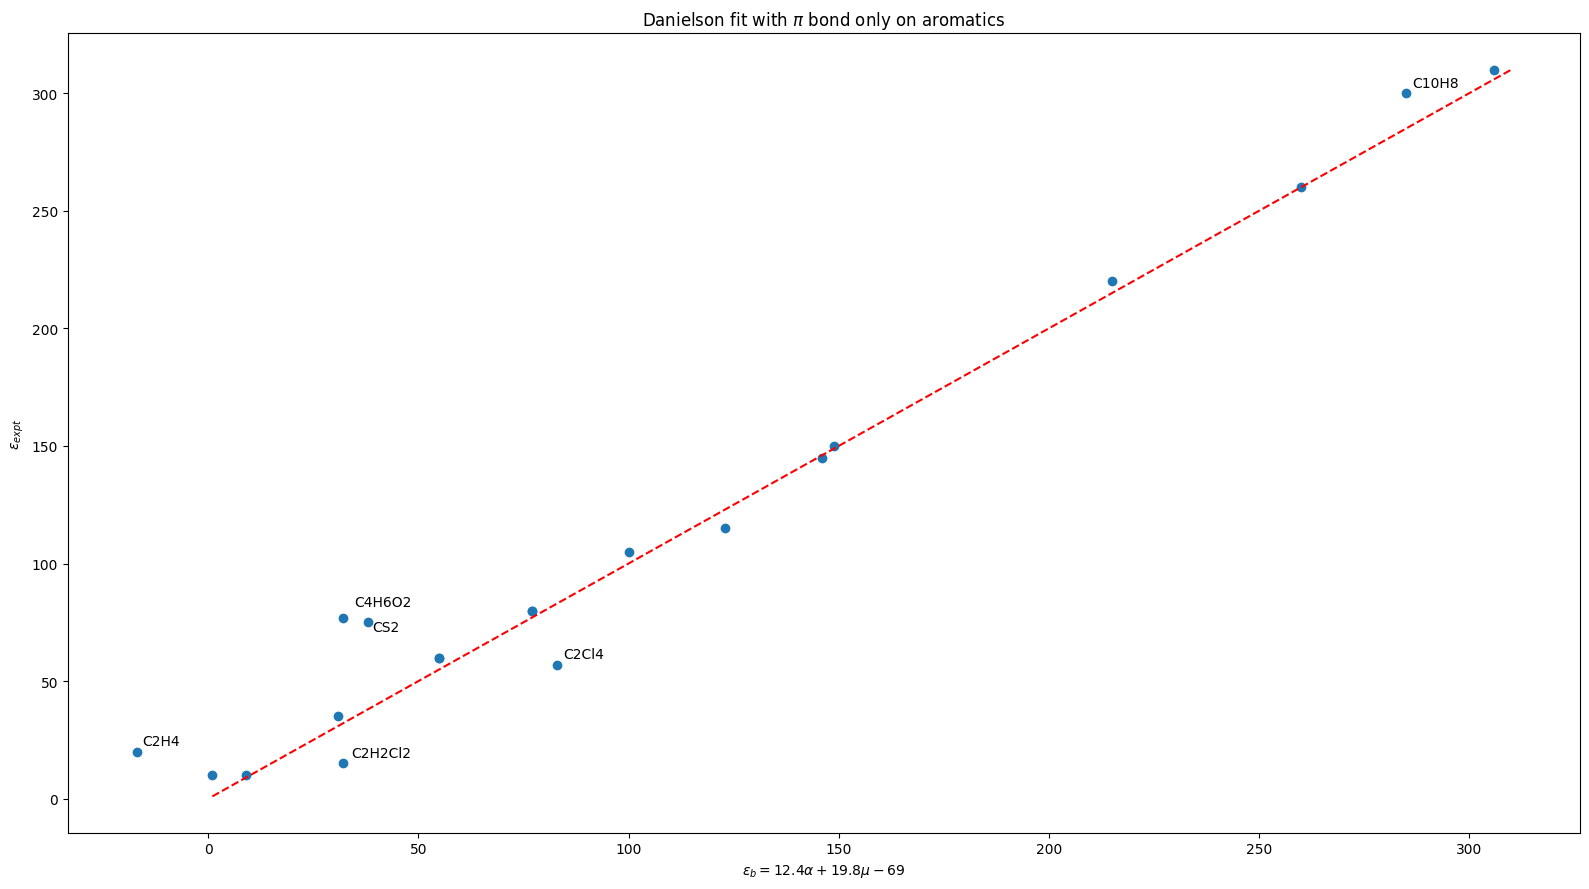

In [14]:
plot_scatter(df_all_apol, "DYS_A", title = "Danielson fit with $\pi$ bond only on aromatics", 
             name_x_axis = r"$\epsilon_b = 12.4 \alpha + 19.8\mu - 69$",
             name_y_axis="$\epsilon_{expt}$")

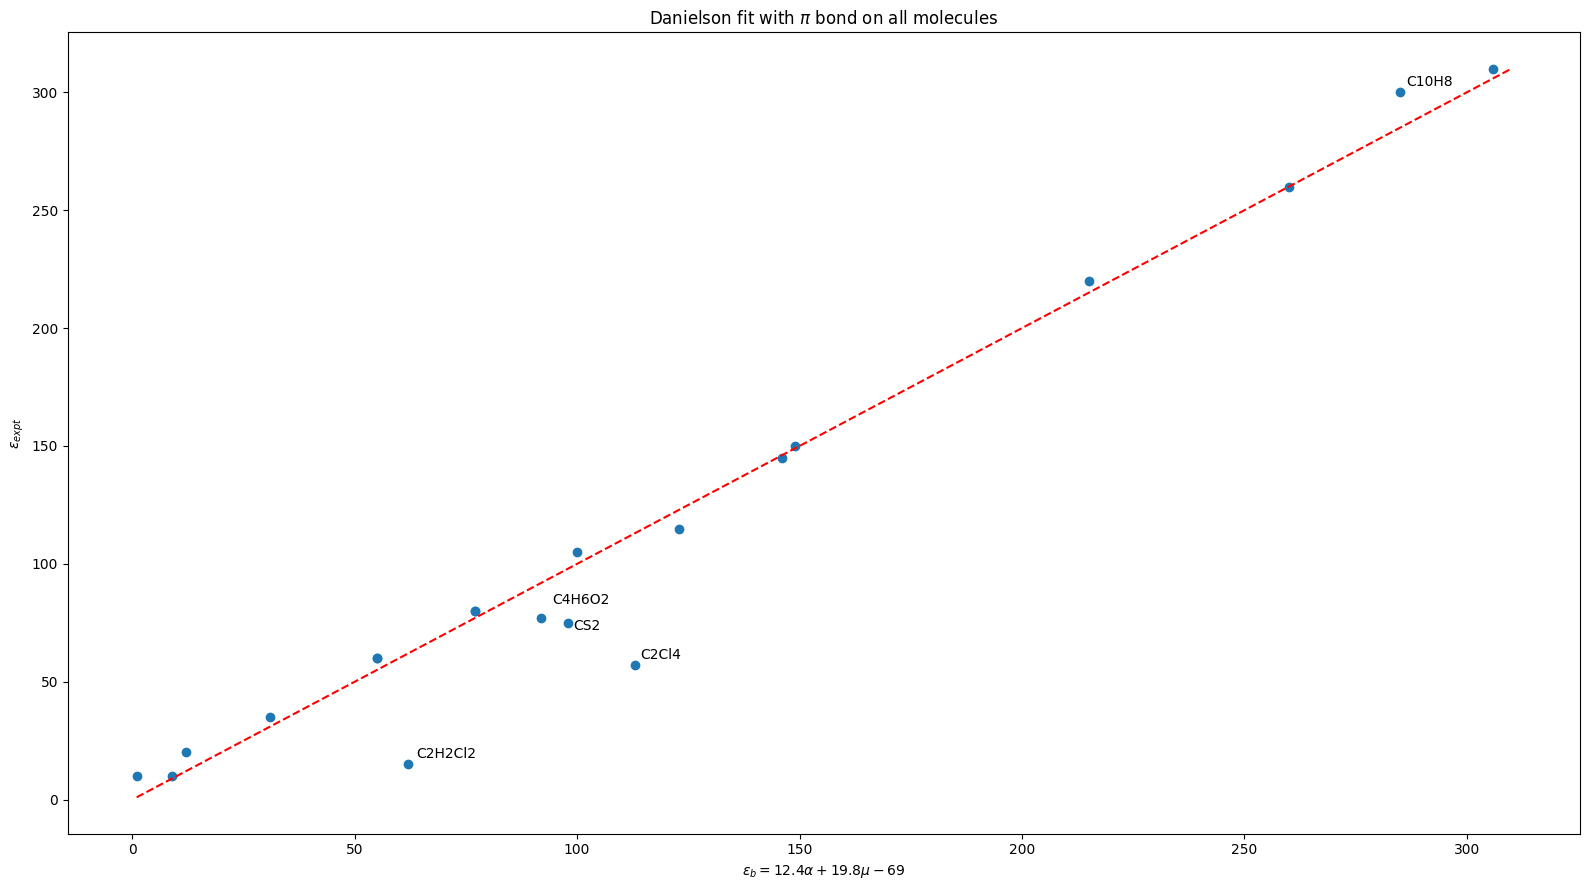

In [15]:
plot_scatter(df_all_apol, "DYS_B", title = "Danielson fit with $\pi$ bond on all molecules", 
             name_x_axis = r"$\epsilon_b = 12.4 \alpha + 19.8\mu - 69$",
             name_y_axis="$\epsilon_{expt}$")

In [16]:
df_all_apol.drop(df_all_apol.columns[:5], axis=1).sort_values(by="mae_apol", ascending=False).head()

,ayy,azz,AlphaB,pi_bond,Dipole,Expt,DYS_A,DYS_B,Apol Preds (SVR),Pol Preds (Stack),Pol+Apol Preds (Stack),MAE DYS_A,MAE DYS_B,mae_apol,mae_pol,mae_pol+apol
7,NaN,NaN,NaN,0,0.0,310,306,306,256.0,NaN,NaN,4,4,54.0,NaN,NaN
8,3.8,3.3,4.2,1,0.0,20,-17,12,-1.0,NaN,20.0,37,8,21.0,NaN,0.0
11,12.3,6.7,10.4,3,0.0,150,149,149,130.0,NaN,119.0,1,1,20.0,NaN,31.0
17,13.9,7.8,12.3,1,0.0,57,83,113,43.0,NaN,108.0,26,56,14.0,NaN,51.0
18,6.7,5.6,8.3,1,0.0,15,32,62,27.0,NaN,16.0,17,47,12.0,NaN,1.0


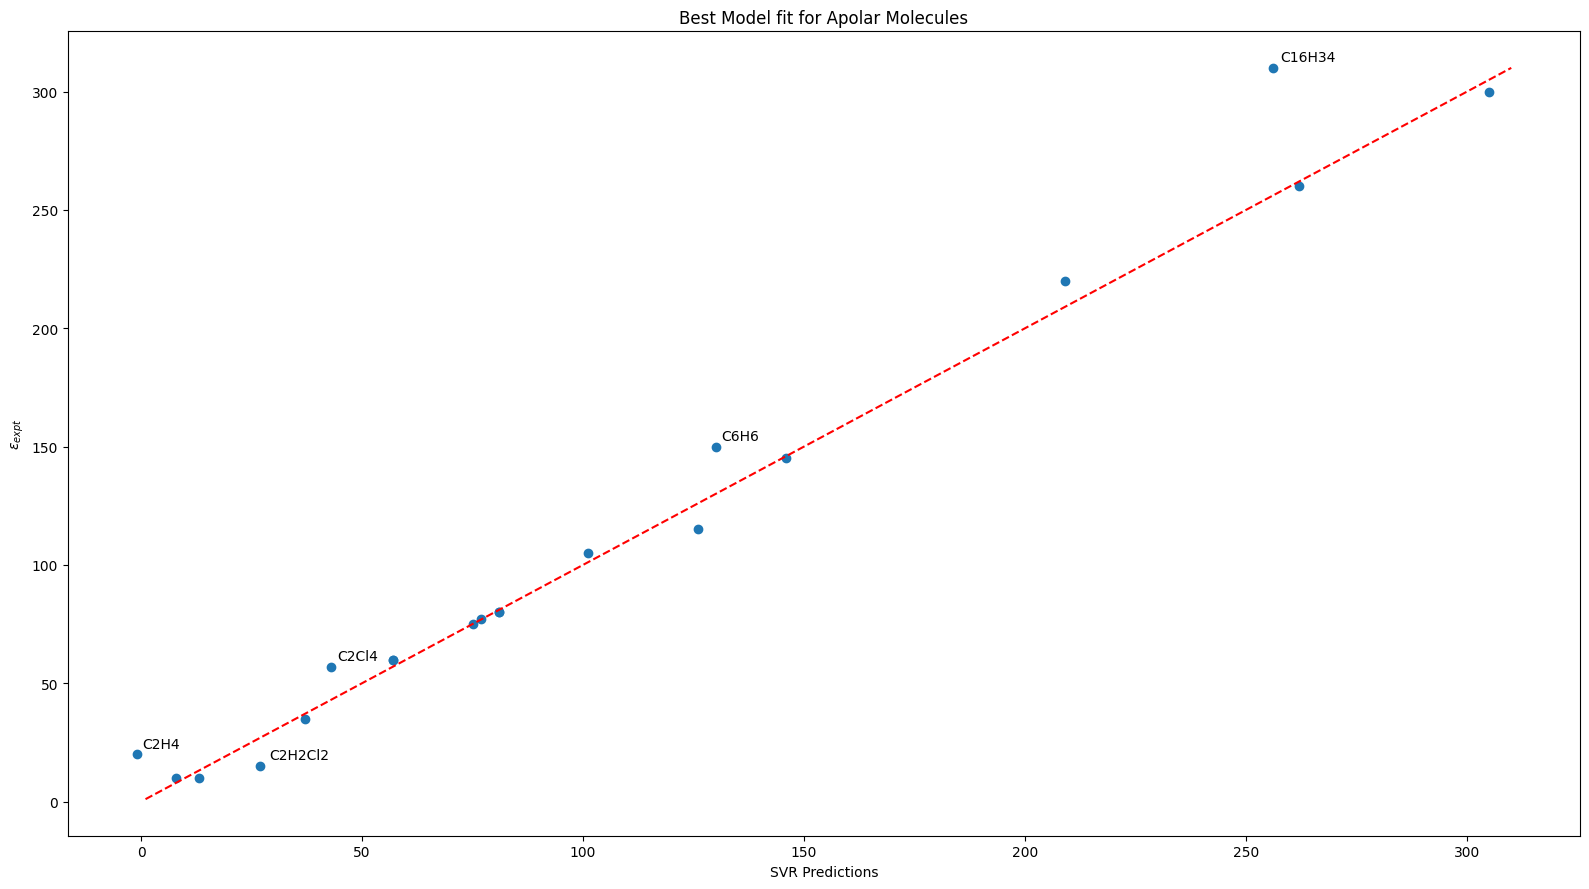

In [17]:
plot_scatter(df_all_apol, "Apol Preds (SVR)", mae_threshold=12,
             name_x_axis="SVR Predictions",
             name_y_axis="$\epsilon_{expt}$",
             title="Best Model fit for Apolar Molecules")

In [18]:
apol_metrics_df = create_metrics_table(df_all_apol, ["DYS_A", "DYS_B", "Apol Preds (SVR)"])
print(apol_metrics_df)

                    MAE   RMSE  MAPE  STD of MAE
DYS_A             11.55  17.68  0.30       13.38
DYS_B             10.90  18.28  0.33       14.68
Apol Preds (SVR)   8.50  14.87  0.17       12.20


# Polares

In [19]:
df_all_pol = df_all.query("Dipole != 0")
df_all_pol.dropna(subset="mae_pol", inplace=True)
df_all_pol.reset_index(drop=True, inplace=True)
df_all_pol.head()

C:\Users\Work Station\AppData\Local\Temp\ipykernel_19552\355516747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_pol.dropna(subset="mae_pol", inplace=True)


,Molecule,Formula,Ei,Alpha,axx,ayy,azz,AlphaB,pi_bond,Dipole,...,DYS_A,DYS_B,Apol Preds (SVR),Pol Preds (Stack),Pol+Apol Preds (Stack),MAE DYS_A,MAE DYS_B,mae_apol,mae_pol,mae_pol+apol
0,Bromoform,CHBr3,10.5,11.3,13.2,13.2,8.6,11.7,0,0.9,...,89,89,NaN,102.0,76.0,41,41,NaN,28.0,54.0
1,Cyclopentanone,C5H8O,9.3,9.0,10.3,9.6,7.6,9.2,1,3.3,...,108,137,NaN,188.0,177.0,122,93,NaN,42.0,53.0
2,Ethyl Acetate(conformer1),C4H8O2,10.0,8.7,10.8,8.9,7.1,8.9,1,2.1,...,80,110,NaN,124.0,131.0,80,50,NaN,36.0,29.0
3,1-Butanol,C4H10O,10.0,8.5,10.4,8.3,7.7,8.8,0,1.6,...,68,68,NaN,102.0,94.0,34,34,NaN,0.0,8.0
4,Chloroform,CHCl3,11.4,8.2,9.4,9.3,6.5,8.4,0,1.1,...,54,54,NaN,64.0,58.0,4,4,NaN,14.0,8.0


In [20]:
df_all_pol[["MAE DYS_A"]].sort_values(by="MAE DYS_A", ascending=False).head(10)

,MAE DYS_A
6,161
14,154
1,122
21,114
12,102
2,80
7,70
9,67
5,57
13,55


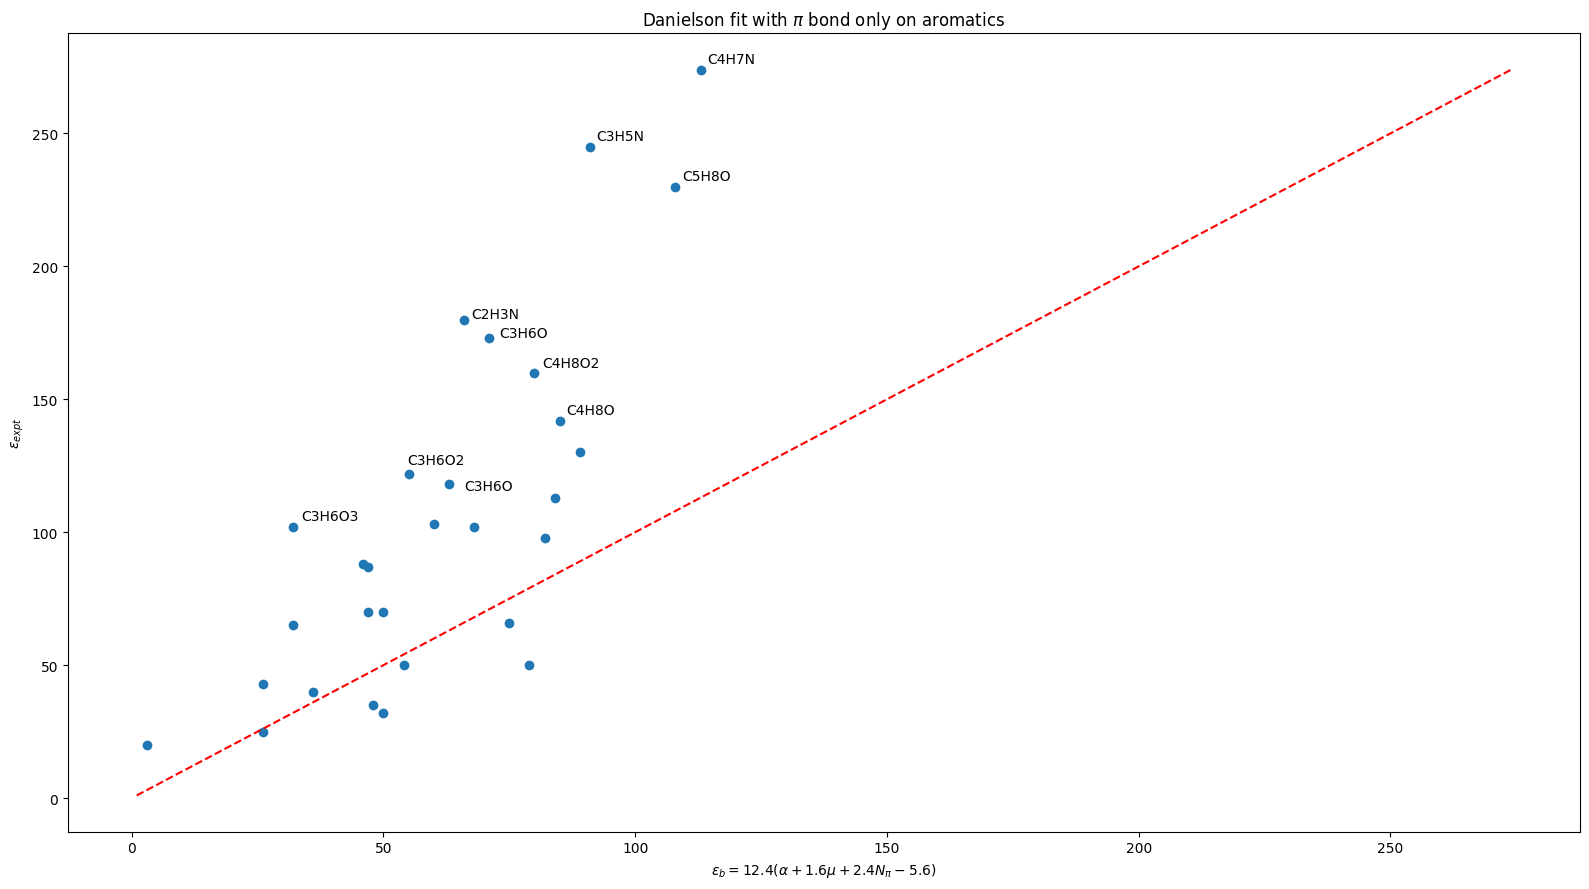

In [21]:
plot_scatter(df_all_pol, "DYS_A", title = "Danielson fit with $\pi$ bond only on aromatics", 
             name_x_axis = r"$\epsilon_b = 12.4 (\alpha + 1.6\mu + 2.4N_{\pi} - 5.6)$",
             name_y_axis="$\epsilon_{expt}$",
             mae_threshold=55)

In [22]:
df_all_pol[["MAE DYS_B"]].sort_values(by="MAE DYS_B", ascending=False).head(10)

,MAE DYS_B
6,101
14,95
1,93
12,72
26,59
21,54
2,50
0,41
10,40
7,40


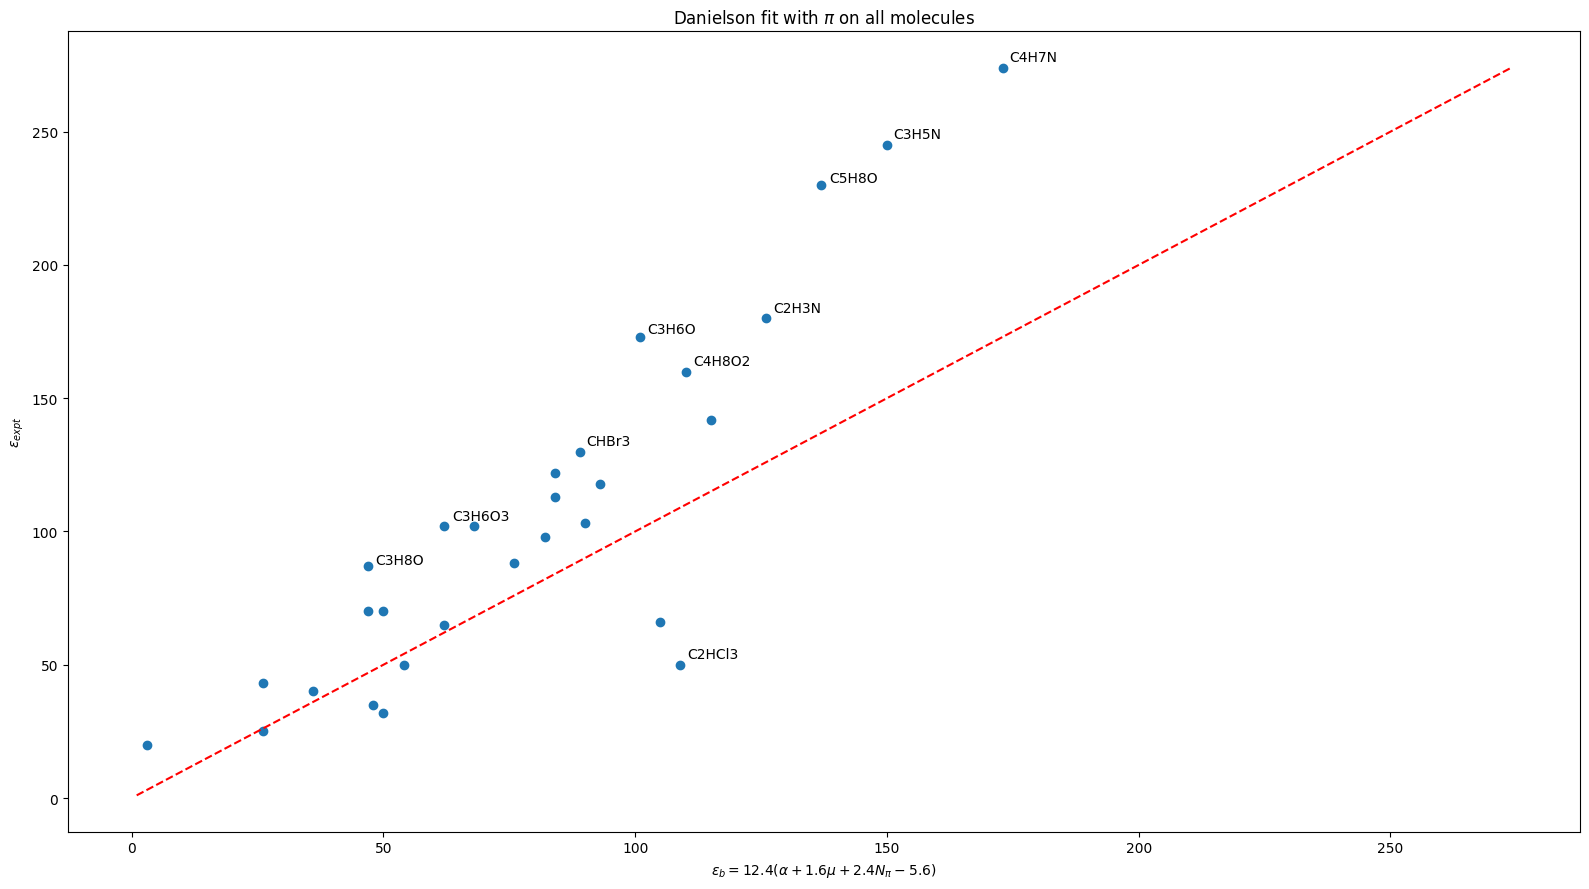

In [23]:
plot_scatter(df_all_pol, "DYS_B", title = "Danielson fit with $\pi$ on all molecules", 
             name_x_axis = r"$\epsilon_b = 12.4 (\alpha + 1.6\mu + 2.4N_{\pi} - 5.6)$",
             name_y_axis="$\epsilon_{expt}$",
             mae_threshold=40)

In [24]:
df_all_pol[["mae_pol"]].sort_values(by="mae_pol", ascending=False).head(10)

,mae_pol
25,50.0
26,47.0
1,42.0
12,40.0
14,36.0
2,36.0
9,33.0
15,31.0
0,28.0
7,17.0


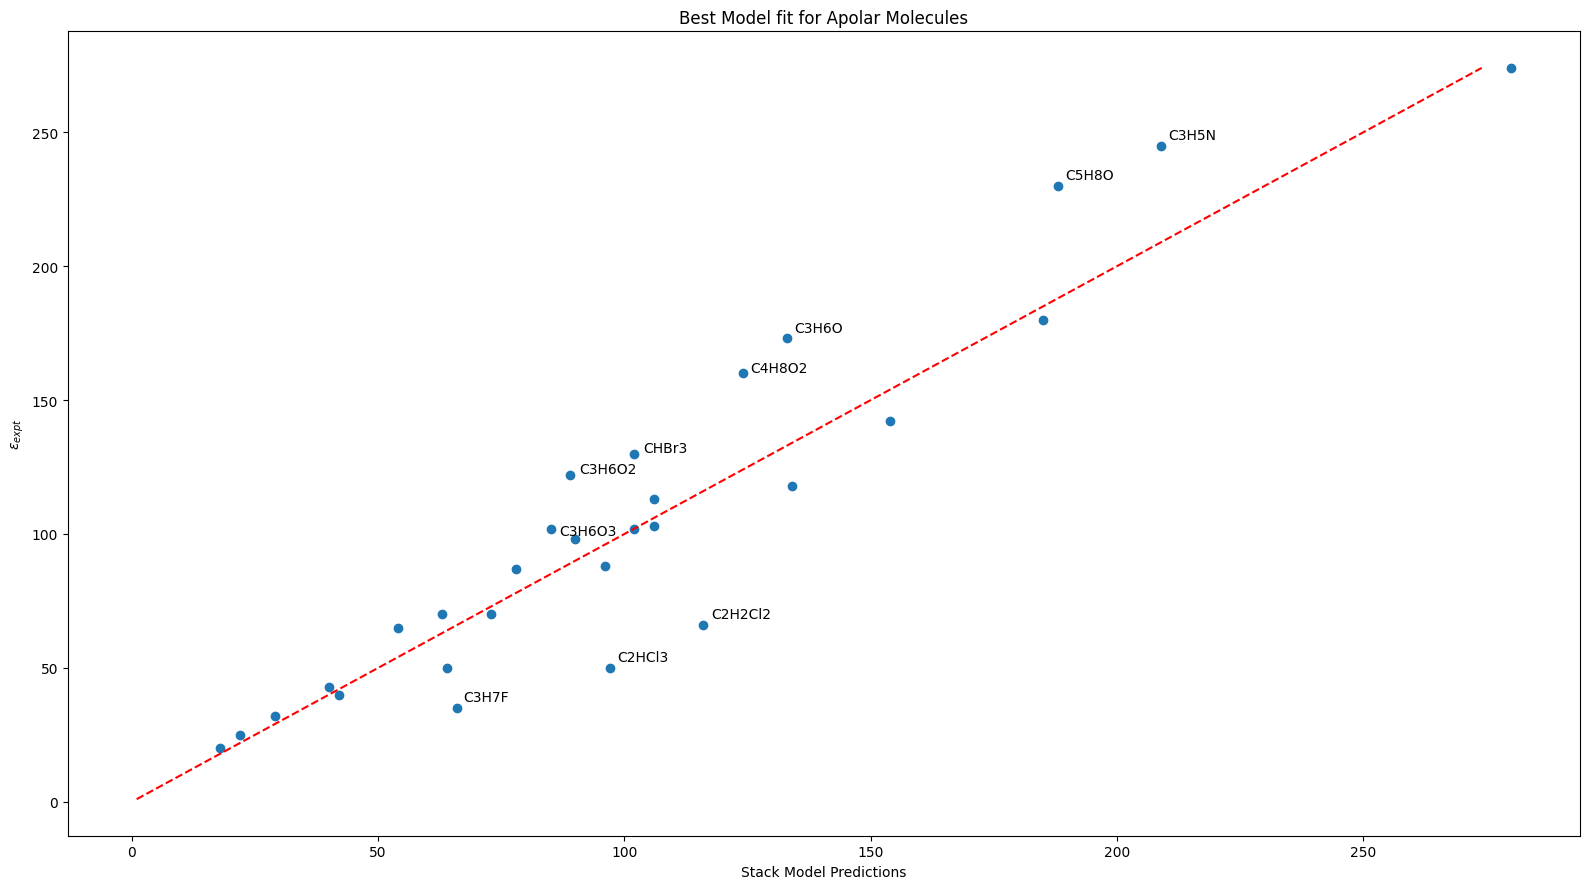

In [25]:
plot_scatter(df_all_pol, "Pol Preds (Stack)", mae_threshold=17,
             name_x_axis="Stack Model Predictions",
             name_y_axis="$\epsilon_{expt}$",
             title="Best Model fit for Apolar Molecules")

In [26]:
create_metrics_table(df_all_pol, ["DYS_A", "DYS_B", "Pol Preds (Stack)"])

,MAE,RMSE,MAPE,STD of MAE
DYS_A,48.79,65.17,0.42,43.20
DYS_B,34.41,43.85,0.34,27.18
Pol Preds (Stack),16.62,22.69,0.20,15.44


In [27]:
df_all_pol

,Molecule,Formula,Ei,Alpha,axx,ayy,azz,AlphaB,pi_bond,Dipole,...,DYS_A,DYS_B,Apol Preds (SVR),Pol Preds (Stack),Pol+Apol Preds (Stack),MAE DYS_A,MAE DYS_B,mae_apol,mae_pol,mae_pol+apol
0,Bromoform,CHBr3,10.5,11.3,13.2,13.2,8.6,11.7,0,0.9,...,89,89,NaN,102.0,76.0,41,41,NaN,28.0,54.0
1,Cyclopentanone,C5H8O,9.3,9.0,10.3,9.6,7.6,9.2,1,3.3,...,108,137,NaN,188.0,177.0,122,93,NaN,42.0,53.0
2,Ethyl Acetate(conformer1),C4H8O2,10.0,8.7,10.8,8.9,7.1,8.9,1,2.1,...,80,110,NaN,124.0,131.0,80,50,NaN,36.0,29.0
3,1-Butanol,C4H10O,10.0,8.5,10.4,8.3,7.7,8.8,0,1.6,...,68,68,NaN,102.0,94.0,34,34,NaN,0.0,8.0
4,Chloroform,CHCl3,11.4,8.2,9.4,9.3,6.5,8.4,0,1.1,...,54,54,NaN,64.0,58.0,4,4,NaN,14.0,8.0
5,Butanal,C4H8O,9.8,8.0,9.6,8.4,6.7,8.2,1,2.8,...,85,115,NaN,154.0,165.0,57,27,NaN,12.0,23.0
6,2-MethylPropionitrile,C4H7N,11.3,8.0,9.7,7.8,6.8,8.1,2,4.2,...,113,173,NaN,280.0,277.0,161,101,NaN,6.0,3.0
7,Dimethylcarbonate,C3H6O3,10.3,7.4,7.7,7.7,6.7,7.4,1,0.5,...,32,62,NaN,85.0,83.0,70,40,NaN,17.0,19.0
8,Ethyl Formate,C3H6O2,10.6,6.9,8.7,6.9,5.5,7.0,1,2.2,...,60,90,NaN,106.0,114.0,43,13,NaN,3.0,11.0
9,Methyl Acetate,C3H6O2,10.2,6.8,8.4,7.1,5.5,7.0,1,2.0,...,55,84,NaN,89.0,96.0,67,38,NaN,33.0,26.0


# Polares + Apolares

In [28]:
df_all_pol_apol = df_all
df_all_pol_apol.dropna(subset="mae_pol+apol", inplace=True)
df_all_pol_apol.reset_index(drop=True, inplace=True)
df_all_pol_apol.head()

,Molecule,Formula,Ei,Alpha,axx,ayy,azz,AlphaB,pi_bond,Dipole,...,DYS_A,DYS_B,Apol Preds (SVR),Pol Preds (Stack),Pol+Apol Preds (Stack),MAE DYS_A,MAE DYS_B,mae_apol,mae_pol,mae_pol+apol
0,Butane,C4H10,10.6,8.1,9.3,7.7,7.2,8.1,0,0.0,...,31,31,37.0,NaN,40.0,4,4,2.0,NaN,5.0
1,Pentane,C5H12,10.4,10.0,11.7,9.4,8.7,10.0,0,0.0,...,55,55,57.0,NaN,63.0,5,5,3.0,NaN,3.0
2,Hexane,C6H14,10.2,11.8,14.3,11.0,10.2,11.9,0,0.0,...,77,77,81.0,NaN,74.0,3,3,1.0,NaN,6.0
3,Heptane,C7H16,9.9,13.7,16.9,12.7,11.7,13.8,0,0.0,...,100,100,101.0,NaN,97.0,5,5,4.0,NaN,8.0
4,Octane,C8H18,10.0,15.5,19.6,14.3,13.2,15.7,0,0.0,...,123,123,126.0,NaN,137.0,8,8,11.0,NaN,22.0


In [29]:
df_all_pol_apol

,Molecule,Formula,Ei,Alpha,axx,ayy,azz,AlphaB,pi_bond,Dipole,...,DYS_A,DYS_B,Apol Preds (SVR),Pol Preds (Stack),Pol+Apol Preds (Stack),MAE DYS_A,MAE DYS_B,mae_apol,mae_pol,mae_pol+apol
0,Butane,C4H10,10.6,8.1,9.3,7.7,7.2,8.1,0,0.0,...,31,31,37.0,NaN,40.0,4,4,2.0,NaN,5.0
1,Pentane,C5H12,10.4,10.0,11.7,9.4,8.7,10.0,0,0.0,...,55,55,57.0,NaN,63.0,5,5,3.0,NaN,3.0
2,Hexane,C6H14,10.2,11.8,14.3,11.0,10.2,11.9,0,0.0,...,77,77,81.0,NaN,74.0,3,3,1.0,NaN,6.0
3,Heptane,C7H16,9.9,13.7,16.9,12.7,11.7,13.8,0,0.0,...,100,100,101.0,NaN,97.0,5,5,4.0,NaN,8.0
4,Octane,C8H18,10.0,15.5,19.6,14.3,13.2,15.7,0,0.0,...,123,123,126.0,NaN,137.0,8,8,11.0,NaN,22.0
5,Nonane,C9H20,10.0,17.4,21.3,14.9,14.0,16.8,0,0.0,...,146,146,146.0,NaN,126.0,1,1,1.0,NaN,19.0
6,Ethylene,C2H4,10.5,4.2,5.4,3.8,3.3,4.2,1,0.0,...,-17,12,-1.0,NaN,20.0,37,8,21.0,NaN,0.0
7,Cyclopropane,C3H6,9.9,5.7,5.8,5.8,5.0,5.5,0,0.0,...,1,1,8.0,NaN,15.0,9,9,2.0,NaN,5.0
8,Cyclohexane,C6H12,9.9,11.8,11.3,11.3,9.8,10.8,0,0.0,...,77,77,81.0,NaN,88.0,3,3,1.0,NaN,8.0
9,Benzene,C6H6,9.3,10.4,12.3,12.3,6.7,10.4,3,0.0,...,149,149,130.0,NaN,119.0,1,1,20.0,NaN,31.0


In [87]:
df_all_pol_apol[["MAE DYS_A"]].sort_values(by="MAE DYS_A", ascending=False).head(10)

,MAE DYS_A
23,161
31,154
18,122
38,114
29,102
19,80
24,70
26,67
22,57
30,55


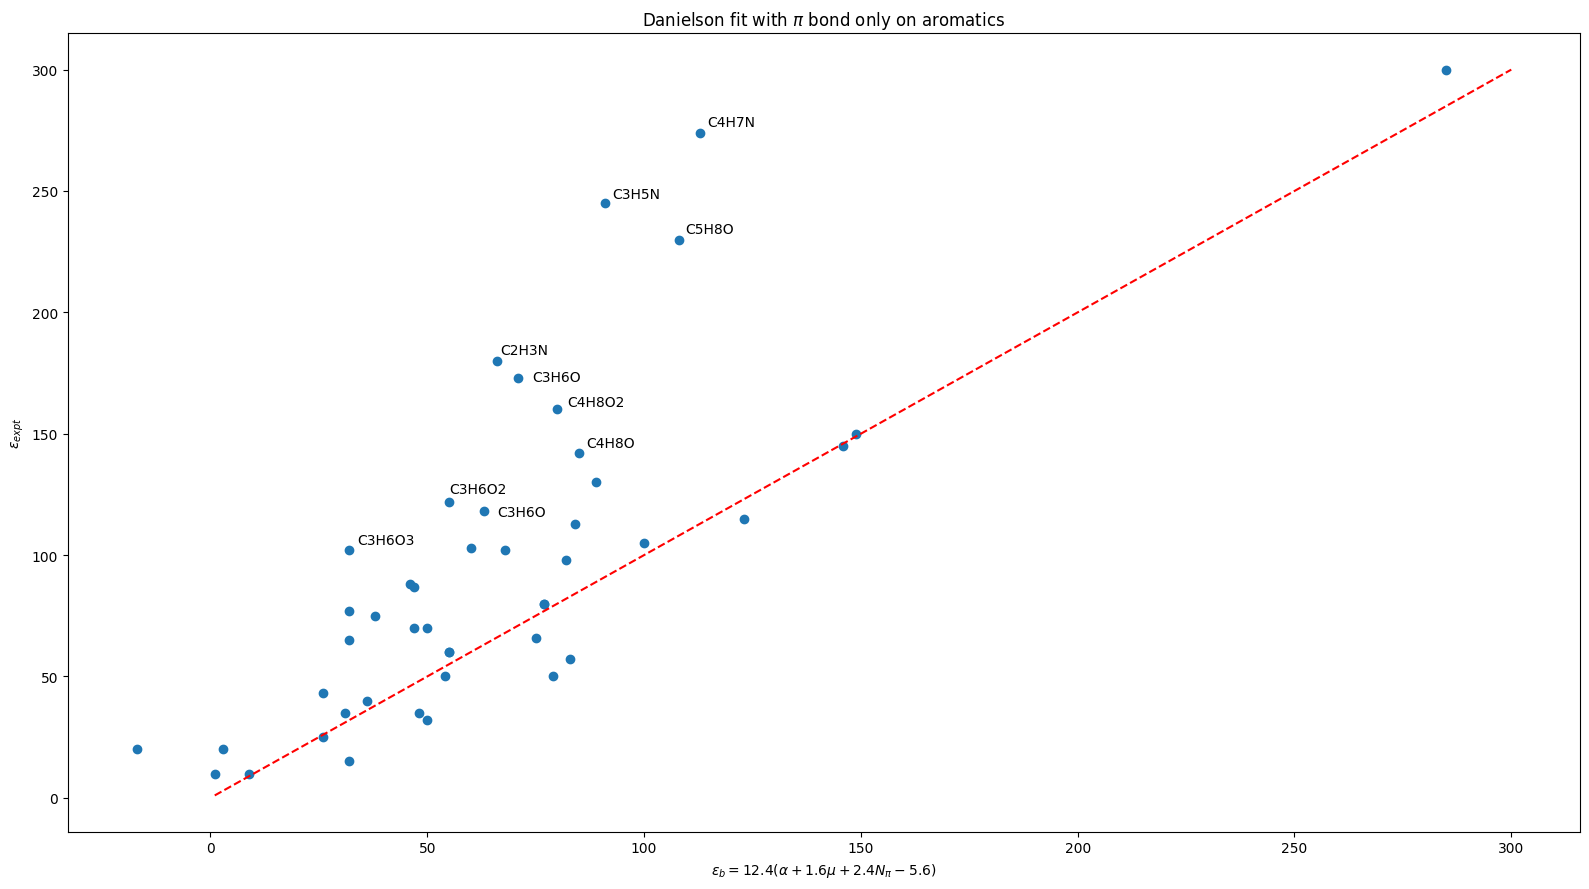

In [88]:
plot_scatter(df_all_pol_apol, "DYS_A", title = "Danielson fit with $\pi$ bond only on aromatics", 
             name_x_axis = r"$\epsilon_b = 12.4 (\alpha + 1.6\mu + 2.4N_{\pi} - 5.6)$",
             name_y_axis="$\epsilon_{expt}$",
             mae_threshold=55)

In [89]:
df_all_pol_apol[["MAE DYS_B"]].sort_values(by="MAE DYS_B", ascending=False).head(10)

,MAE DYS_B
23,101
31,95
18,93
29,72
43,59
14,56
38,54
19,50
15,47
17,41


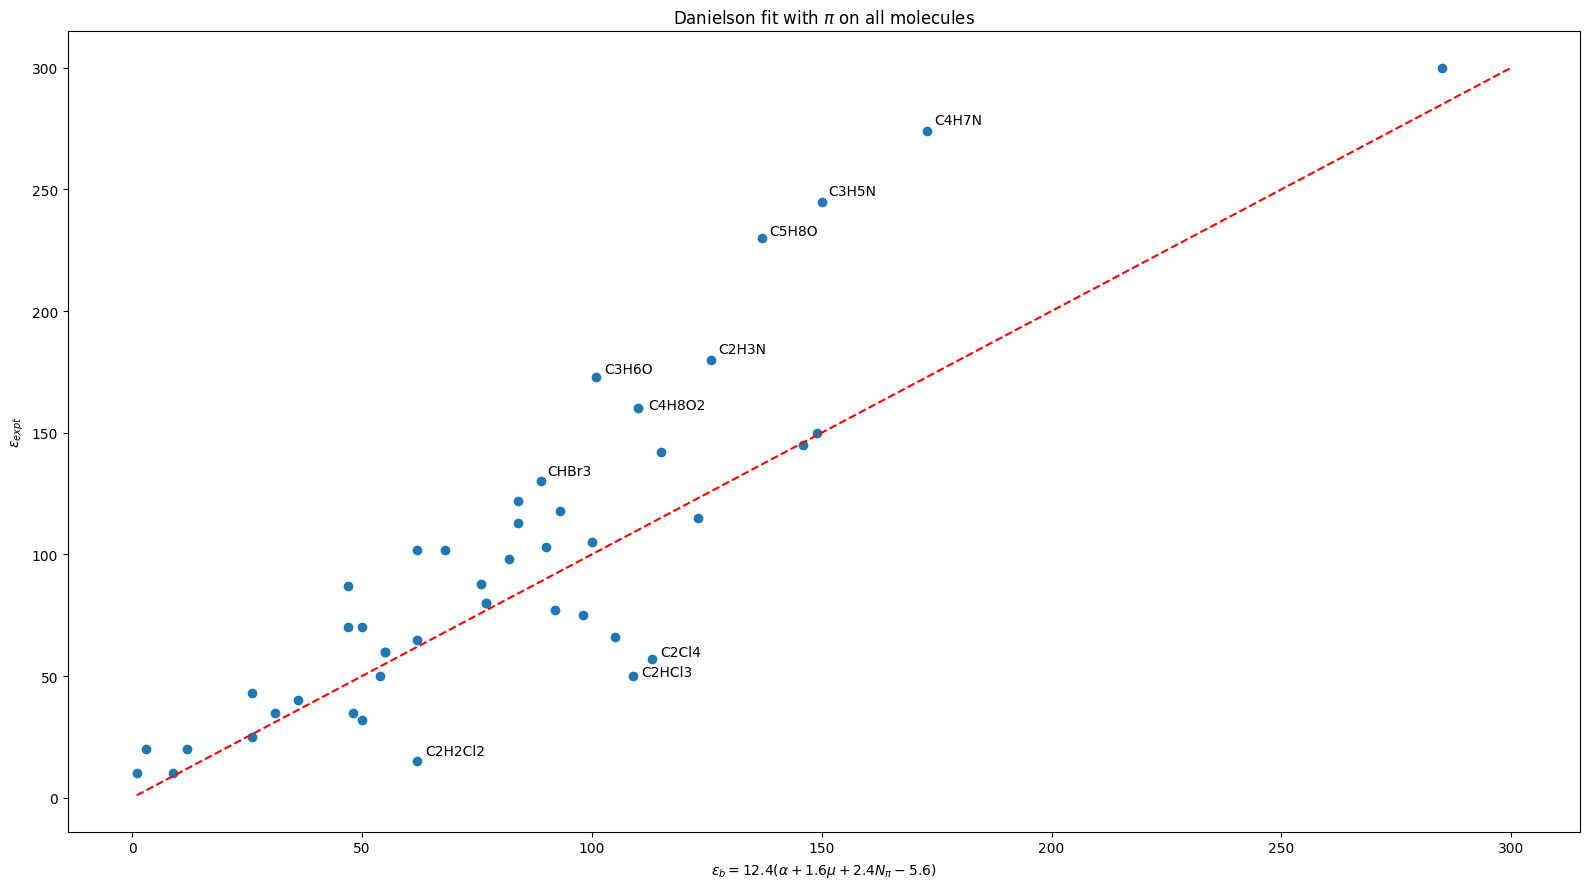

In [90]:
plot_scatter(df_all_pol_apol, "DYS_B", title = "Danielson fit with $\pi$ on all molecules", 
             name_x_axis = r"$\epsilon_b = 12.4 (\alpha + 1.6\mu + 2.4N_{\pi} - 5.6)$",
             name_y_axis="$\epsilon_{expt}$",
             mae_threshold=41)

In [91]:
df_all_pol_apol[["mae_pol+apol"]].sort_values(by="mae_pol+apol", ascending=False).head(10)

,mae_pol+apol
10,115.0
17,54.0
18,53.0
14,51.0
29,44.0
42,42.0
31,35.0
38,35.0
43,31.0
9,31.0


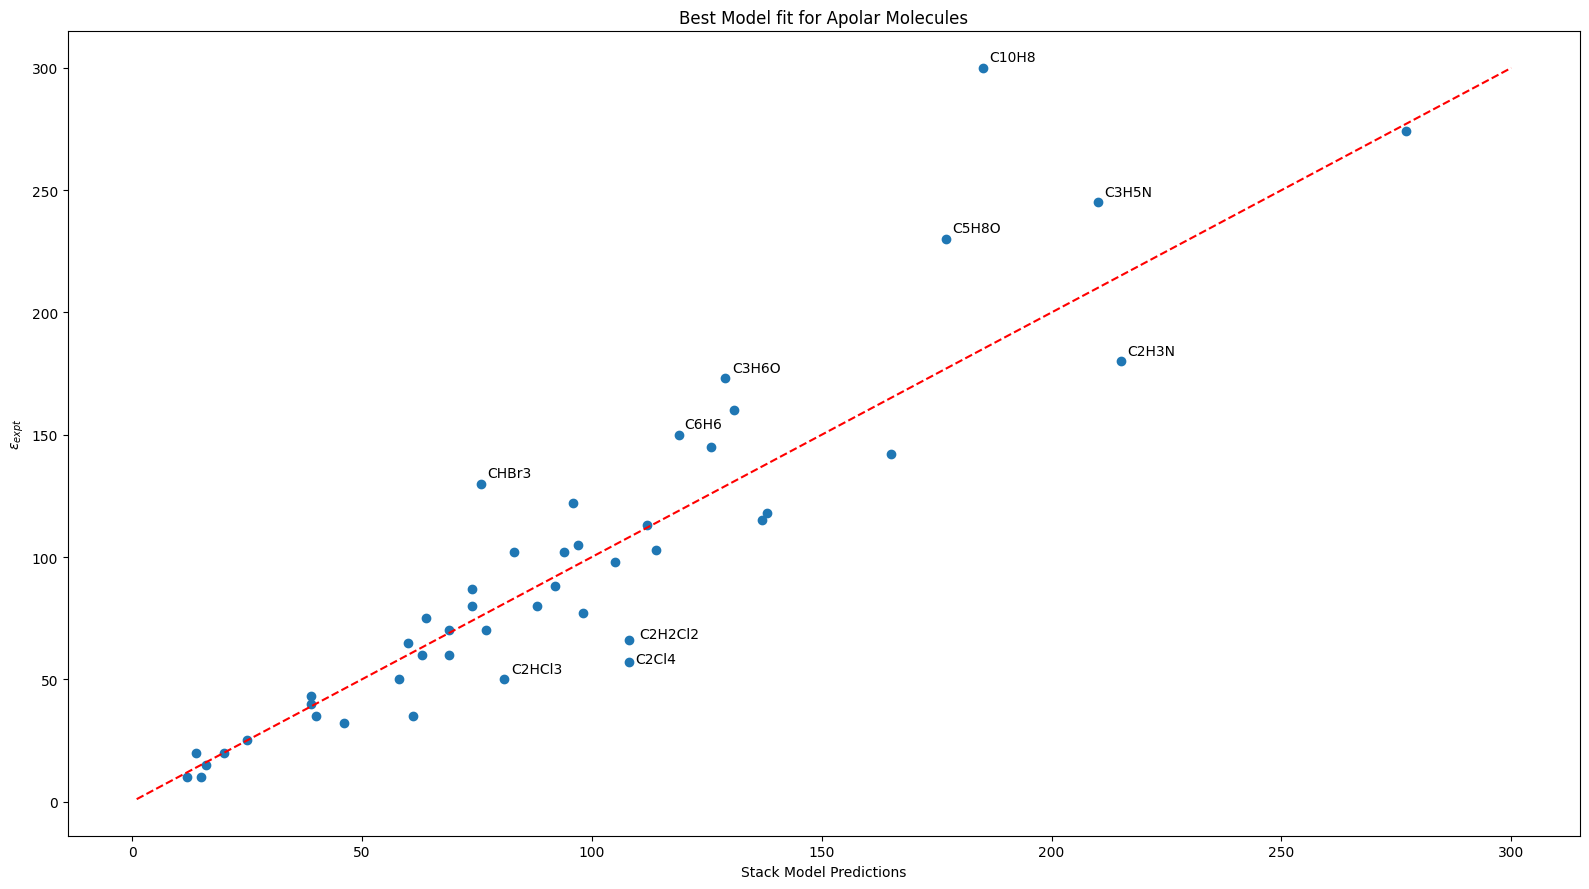

In [92]:
plot_scatter(df_all_pol_apol, "Pol+Apol Preds (Stack)", mae_threshold=31,
             name_x_axis="Stack Model Predictions",
             name_y_axis="$\epsilon_{expt}$",
             title="Best Model fit for Apolar Molecules")

In [93]:
create_metrics_table(df_all_pol_apol, ["DYS_A", "DYS_B", "Pol+Apol Preds (Stack)"])

,MAE,RMSE,MAPE,STD of MAE
DYS_A,35.59,53.04,0.40,39.32
DYS_B,26.24,36.83,0.36,25.85
Pol+Apol Preds (Stack),18.41,27.83,0.20,20.87
